## Set up imports, load model and virtual physiology data

In [ ]:
import math
import numpy as np
import pickle

import scipy
from scipy import ndimage
import scipy.optimize as opt
from scipy import signal

import torch
import torch.nn as nn
import torch.optim as optim

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import animation, rc

from IPython.display import HTML
%matplotlib inline

# Import custom modules
from lib.FramesDataset import FramesDataset
from lib import network

# Global variables
HIDDEN_UNITS = 1600
FRAME_SIZE = 20
WARMUP = 4
MODE = 'hierarchical'
T_STEPS = 45

PATHS = [
    # 15px
    'hierarchical-233450examples-15framesize-45tsteps-4warmup-2000epochs-1600units-0.0001lr-0.25gradclip-1e-06L1/0.5beta',
    # 20px
    'hierarchical-290290examples-20framesize-45tsteps-4warmup-2000epochs-1600units-0.0001lr-0.25gradclip-1e-6.25L1/0.2beta',
    'hierarchical-290290examples-20framesize-45tsteps-4warmup-2000epochs-1600units-0.0001lr-0.25gradclip-1e-6.25L1/0.5beta',
    # 20px, 4000 epochs
    'model-hierarchical-290290examples-20framesize-45tsteps-4warmup-4000epochs-1600units-0.0001lr-0.25gradclip-1e-6.25L1/0.2beta'
]
PATH = PATHS[3]

# Set device to use on network
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using", DEVICE)

# Load previously trained model
model = network.RecurrentTemporalPrediction.load(
    hidden_units = HIDDEN_UNITS,
    frame_size = FRAME_SIZE,
    warmup = WARMUP,
    mode = MODE,
    path = './models/' + PATH + '.pt'
)

# Load dataset
if False:
    train_dataset = FramesDataset('./datasets/processed_dataset_15px_20tsteps.npy', 'train', WARMUP)
    train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128)
    print("Training dataset length:", len(train_dataset))

# Plot loss history
with open('./models/' + PATH + '.pickle', 'rb') as p:
    loss_history = pickle.load(p)
    
plt.loglog(loss_history);
plt.xlabel('Epoch')
plt.ylabel('Mean loss')
plt.show() 

In [ ]:
# Load or save previously generated physiology data

mode = 'SAVE'
path = './virtual_physiology/' + PATH + '.pickle'

if mode == 'SAVE':
    data = {
        "physiology_data_group1": physiology_data_group1,
        "physiology_data_group2": physiology_data_group2,
        "averaged_stimuli_group1": averaged_stimuli_group1,
        "averaged_stimuli_group2": averaged_stimuli_group2
    }

    with open(path, 'wb') as handler:
        pickle.dump(data, handler)
        print('Saved')
elif mode == 'LOAD':
    with open(path, 'rb') as handler:
        data = pickle.load(handler)
        
        physiology_data_group1 = data["physiology_data_group1"]
        physiology_data_group2 = data["physiology_data_group2"]
        averaged_stimuli_group1 = data["averaged_stimuli_group1"]
        averaged_stimuli_group2 = data["averaged_stimuli_group2"]
        print('Loaded')

In [ ]:
# Plot weight matrices and weights distribution
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(1/3), dpi=150)

axs[0].hist(model.rnn.weight_hh_l0.cpu().detach().numpy().flat, log=True)
axs[0].set_xlabel('Weight')
axs[0].set_ylabel('Log frequency')
axs[0].set_title('H-H RNN weight distribution')

im = axs[1].imshow(model.rnn.weight_hh_l0.cpu().detach().numpy(), vmin=-0.01, vmax=0.01)
axs[1].set_xlabel('Hidden weights')
axs[1].set_ylabel('Hidden weights')
axs[1].set_title("H-H RNN weights")
plt.colorbar(im)

## Process virtual physiology data and get RF locations

In [ ]:
# Produce spike-triggered average
def max_abs_normalize (arr):
    return arr / np.max(np.abs(arr))

def normalize (arr):
    return np.array([
        (lambda a: (a-np.mean(a)) / np.std(a))(b)
        for b in arr
    ])

n_rand_stimuli = 250

stimuli = {}
unit_activity = {}

for i in range(HIDDEN_UNITS):
    stimuli[i] = []
    unit_activity[i] = []

for i in range(n_rand_stimuli):
    if i % 10 == 9:
        print('Random noise trial {}'.format(i+1))
    
    noise_shape = (1, WARMUP+T_STEPS, FRAME_SIZE**2)
    noise = np.random.normal(loc=0, scale=1, size=noise_shape)
    noise = torch.Tensor(noise).to(DEVICE)
    
    _, hidden_state = model(noise)
    
    for t_step in range(WARMUP, WARMUP+T_STEPS):
        units = hidden_state[0, t_step, :] # Output t_step
        for i, unit in enumerate(units):
            if unit > 0:
                weighted_stimulus = noise[0, t_step, :] * unit
                stimuli[i].append(weighted_stimulus.cpu().detach().numpy())
                unit_activity[i].append(unit.cpu().detach().numpy())
                
averaged_stimuli_group1 = [], []
averaged_stimuli_group2 = [], []

for i in range(HIDDEN_UNITS):
    if i % 100 == 99:
        print('Averaging across hidden unit {}'.format(i+1))
    
    stimuli_len = len(stimuli[i])
    if stimuli_len:
        stimulus = np.sum(stimuli[i], 0)/np.sum(unit_activity[i]) # Weighted average

        if i < HIDDEN_UNITS//2:
            averaged_stimuli_group1[0].append(stimulus)
            averaged_stimuli_group1[1].append(i)
        else:
            averaged_stimuli_group2[0].append(stimulus)
            averaged_stimuli_group2[1].append(i)
averaged_stimuli_group1 = np.array(averaged_stimuli_group1[0]), np.array(averaged_stimuli_group1[1])
averaged_stimuli_group2 = np.array(averaged_stimuli_group2[0]), np.array(averaged_stimuli_group2[1])
        
print('Finished averaging stimuli')

In [ ]:
# Virtual physiology

# Constants
OSI_THRESH = 0.4 # Both from Ko et al. (2011)
DSI_THRESH = 0.3

MEAN_RESPONSE_OFFSET = 5
CURVE_FIT_OFFSET = 5

SPATIAL_FREQUENCIES = np.arange(1/FRAME_SIZE, 0.5, 1/FRAME_SIZE) # Cycles / pixel
ORIENTATIONS = np.arange(0, 360, 5) # Degrees
TEMPORAL_FREQUENCIES = np.arange(0.05, 0.55, 0.05) # Cycles / time step

def get_f_value (activity):
    # Fit to sine
    def func(x, a, b, c, d, e):
        return e*x + a*np.sin(b*x + c) + d

    params = []
    mse = []
    increment = []

    MSE_threshold = 5

    # Because the unit output has a floor of 0, the curve optimizer function might
    # fail to fit the function unless we shift the unit's response up
    # Shift it up by 0-150, returning the increment (shift), parameters and MSE for each increment
    for i in range(0, 150, 5):
        x = np.arange(len(activity[CURVE_FIT_OFFSET:]))
        y = np.array(activity[CURVE_FIT_OFFSET:]) + i

        # In case it fails to find optimal parameters, wrap in a try block
        try:
            bounds = (
                [-np.inf, 0, -np.inf, -np.inf, -np.inf],
                [np.inf, np.inf, np.inf, np.inf, np.inf] # Set lower bound of 1 for frequency
            )
            
            optimizedParameters, pcov = opt.curve_fit(func, x, y, method='trf', bounds=bounds);
            y_est = func(x, *optimizedParameters)
            
            params.append(optimizedParameters)
            mse.append(np.mean(np.sum((y-y_est)**2)))
            increment.append(i)
        except:
            continue

    # Return false if no good fits were found for any combination
    if len(params):
        # Get the index of the lowest MSE, use this to find the
        # Corresponding parameters used
        idx = np.argmin(mse)
        best_params = params[idx]
        best_i = increment[idx]
        best_mse = mse[idx]

        f0 = np.mean(activity[CURVE_FIT_OFFSET:]) # Average unit activity
        f1 = (abs(best_params[0])) # Absolute of the amplitude of the fitted sine

        y_est = func(np.arange(len(activity[CURVE_FIT_OFFSET:])), *best_params) - best_i
    
        if best_mse <= MSE_threshold and f0 != 0: # Reject f values for those units with poor sine fits
            return f1/f0, y_est                   # as these are unlikely to be reliable
        else:
            return False, False
    else:
        return False, False

def generate_gratings (spatial_freq, orient, temporal_freq, grating_amplitude=0.5, frames=30):
    # Convert to measure relative to frame size
    spatial_freq = spatial_freq*FRAME_SIZE
    
    gratings = []
    for i in range(frames):
        extended_val = 4 # For a full field grating, make it 4 times larger than
                         # the frame so it can be cropped when rotated and still be full-field
        extended_size = FRAME_SIZE*extended_val
        crop_slice = slice( # Crop extended size grating to be the same size as the frame
            (extended_size-FRAME_SIZE)//2, (extended_size-FRAME_SIZE)//2+FRAME_SIZE
        )
        
        phase = 2*np.pi*i*temporal_freq # Shift  by a fraction of how many cycles per time step

        x_range = np.linspace(0, 2*np.pi, num=extended_size)
        y = np.sin(x_range*spatial_freq*extended_val + phase)*grating_amplitude

        grating = np.repeat(y, extended_size, axis=0).reshape((extended_size, extended_size))
        grating = ndimage.rotate(grating, -orient, reshape=False) # -orient to correct for 'default' counterclockwise rotation
        grating = grating[crop_slice, crop_slice]
        grating = grating.reshape(FRAME_SIZE**2)
        gratings.append(grating)
    
    gratings = np.array([gratings])
    gratings = torch.Tensor(gratings).to(DEVICE)

    return gratings

# Returns a dict of grating responses { unit_idx: responses_array }
def get_grating_responses (model, grating, unit_idxs):
    responses = {}
    for idx in unit_idxs:
        responses[idx] = []
    
    _, hidden_state = model(grating)
    for t_step in range(WARMUP, WARMUP+T_STEPS):
        for idx in unit_idxs:
            unit_activity = hidden_state[0, t_step, idx]
            responses[idx].append(unit_activity.cpu().detach().numpy())
            
    return responses

# Takes orientation tuning curve at max tf and sf
# Returns DSI, OSI
def get_direction_orientation_selectivity (tuning_curve):    
    dir_pref_idx = np.where(tuning_curve == np.max(tuning_curve))[0]
    dir_pref = ORIENTATIONS[dir_pref_idx][0]
    dir_pref_resp = tuning_curve[dir_pref_idx][0]
    
    dir_opp = (dir_pref + 180) % 360
    dir_opp_idx = np.where(ORIENTATIONS == dir_opp)[0]
    dir_opp_resp = tuning_curve[dir_opp_idx][0]
    
    orient_pref_resp = dir_pref_resp
    
    orient_orth = (dir_pref + 90) % 360
    orient_orth_idx = np.where(ORIENTATIONS == orient_orth)[0]
    orient_orth_resp = tuning_curve[orient_orth_idx][0]
    
    DSI = (dir_pref_resp - dir_opp_resp) / (dir_pref_resp + dir_opp_resp)
    OSI = (orient_pref_resp - orient_orth_resp) / (orient_pref_resp + orient_orth_resp)
    
    return DSI, OSI

# Returns array of physiology data
# { "unit_idx", "tuning_curve", "sf", "orientation", "preferred_response", "f" }
def get_physiology_data (averaged_hidden_units):
    hidden_unit_rfs, hidden_unit_idxs = averaged_hidden_units    
    
    physiology_data = []

    # Dictionary structures containing mean response and complete response for
    # each sf, orient and tf combination
    unit_responses = {}
    mean_unit_responses = {}
    for idx in hidden_unit_idxs:
        unit_responses[idx] = np.zeros((
            len(SPATIAL_FREQUENCIES),
            len(ORIENTATIONS),
            len(TEMPORAL_FREQUENCIES),
            T_STEPS
        ))
        mean_unit_responses[idx] = np.zeros((
            len(SPATIAL_FREQUENCIES),
            len(ORIENTATIONS),
            len(TEMPORAL_FREQUENCIES)
        ))

        
    count = 0
    max_count = mean_unit_responses[[k for k in mean_unit_responses.keys()][0]].size
        
    # Loop through each sf, orient, tf combination for each unit
    # Add response and mean response to structures
    for sf_idx, sf in enumerate(SPATIAL_FREQUENCIES):
        for deg_idx, deg in enumerate(ORIENTATIONS):
            for tf_idx, tf in enumerate(TEMPORAL_FREQUENCIES):
                gratings = generate_gratings(sf, deg, tf, grating_amplitude=3, frames=WARMUP+T_STEPS)
                grating_responses = get_grating_responses(model, gratings, hidden_unit_idxs)

                for unit_idx in hidden_unit_idxs:
                    unit_response = grating_responses[unit_idx]
                    # Actual response
                    unit_responses[unit_idx][sf_idx, deg_idx, tf_idx] = unit_response
                    # Mean response
                    mean_unit_responses[unit_idx][sf_idx, deg_idx, tf_idx] = np.mean(unit_response[MEAN_RESPONSE_OFFSET:])                                                                                        
                
                if count % 100 == 99:
                    print("Finished param combination {}/{}".format(count+1, max_count)) 
                count += 1
    print("Finished tuning curve")

    for i, unit_idx in enumerate(mean_unit_responses):
        # Get argmax of tuning curve parameters
        tuning_curve = mean_unit_responses[unit_idx]
        sf_idx, orient_idx, tf_idx = np.where(tuning_curve == np.max(tuning_curve))
        
        max_sf = SPATIAL_FREQUENCIES[sf_idx[0]]
        max_orient = ORIENTATIONS[orient_idx[0]]
        max_tf = TEMPORAL_FREQUENCIES[tf_idx[0]]
        max_grating_response = unit_responses[unit_idx][sf_idx[0], orient_idx[0], tf_idx[0]]
        
        # Get f value and estimated sine curve fit
        f, y_est = get_f_value(max_grating_response)
        
        # Get OSI and DSI measures
        DSI, OSI = get_direction_orientation_selectivity(
            tuning_curve[sf_idx[0], :, tf_idx[0]]
        )
        
        # Append all physiology values to datastructure
        physiology_data.append({
            "unit_idx": unit_idx,
            "rf": hidden_unit_rfs[np.where(hidden_unit_idxs == unit_idx)[0]],
            "tuning_curve": tuning_curve,
            "sf": max_sf,
            "orientation": max_orient,
            "tf": max_tf,
            "DSI": DSI,
            "OSI": OSI,
            "preferred_response": max_grating_response,
            "mean_response": np.mean(max_grating_response),
            "f": f,
            "y_est": y_est
        })

        if i % 100 == 99:
            print("Finished unit {} / {}".format(i+1, len(hidden_unit_idxs)))

    print("Finished all physiology data processing")
    
    # Reject low mean response units (< 1% of max mean response)
    physiology_data = np.array(physiology_data)
    physiology_data_mean_resp = np.array([u["mean_response"] for u in physiology_data])
    thresh = max(physiology_data_mean_resp) * 0.01 # Get 1% of max mean value
    physiology_data = physiology_data[physiology_data_mean_resp >= thresh]

    return physiology_data

physiology_data_group1 = get_physiology_data(averaged_stimuli_group1)
physiology_data_group2 = get_physiology_data(averaged_stimuli_group2)

In [ ]:
# Spatial localization

def generate_moving_bar (direction, x, y, bar_amplitude):
    bar_size = 5

    frames_len = 20
    
    stimuli = np.zeros((frames_len+10, FRAME_SIZE, FRAME_SIZE))

    for i in range(frames_len):
        bar_position = 0
        square = np.ones((bar_size, bar_size))*bar_amplitude

        if direction == 0 or direction == 270:
            bar_position = (bar_size - i) % bar_size
        else:
            bar_position = i%(bar_size) 

        if direction == 0 or direction == 180:
            square[bar_position, :] = -bar_amplitude
        else:
            square[:, bar_position] = -bar_amplitude

        stimulus = np.zeros((FRAME_SIZE, FRAME_SIZE))
        stimulus[y:y+bar_size, x:x+bar_size] = square

        stimuli[i+10, :, :] = stimulus

    stimuli = stimuli.reshape(frames_len+10, FRAME_SIZE**2)
    stimuli = torch.Tensor(stimuli).unsqueeze(0).to(DEVICE)
    
    return stimuli

def get_RF_responses (model, stimuli, unit_idxs):
    responses = {}
    for idx in unit_idxs:
        responses[idx] = []
    
    _, hidden_state = model(stimuli)
    for t_step in range(stimuli.shape[1]):
        for idx in unit_idxs:
            unit_activity = hidden_state[0, t_step, idx]
            responses[idx].append(unit_activity.cpu().detach().numpy())
            
    return responses

def get_unit_heatmap (unit, bar_amplitude):
    unit_idx = unit["unit_idx"]
    responses = np.zeros((4, 15, 15))

    for orient_idx, orient in enumerate([0, 90, 180, 270]):
        for row_idx, row in enumerate(np.arange(15)):
            for col_idx, col in enumerate(np.arange(15)):
                stimuli = generate_moving_bar(orient, col, row, bar_amplitude)
                resp = get_RF_responses(model, stimuli, [unit_idx])[unit_idx]
                resp = resp[10:]-np.mean(resp[:10])
                responses[orient_idx, row_idx, col_idx] = np.mean(resp)
                
    unit["rf_heatmap"] = np.mean(responses, 0)

def process_unit_heatmaps (units):
    for i, unit in enumerate(units):
        get_unit_heatmap(unit, 0.5)
        print("Processed {} / {}".format(i+1, len(units)))
    print('\nFinished\n')
    
def get_unit_heatmap_centre (unit):
    response = unit["rf_heatmap"] 
    smoothed = ndimage.gaussian_filter(response, 1)

    thresh = np.max(smoothed) - np.std(smoothed)
    thresholded = smoothed > thresh

    centre = ndimage.center_of_mass(thresholded)
    scale_factor = FRAME_SIZE/response.shape[0]
    
    unit["position"] = (centre[0] * scale_factor, centre[1] * scale_factor)
    

process_unit_heatmaps(physiology_data_group1)
process_unit_heatmaps(physiology_data_group2)

for unit in physiology_data_group1:
    get_unit_heatmap_centre (unit)
print("Done 1")
    
for unit in physiology_data_group2:
    get_unit_heatmap_centre (unit)
print("Done 2")

In [ ]:
# Visualize spatial responses

fig = plt.figure(dpi=300, figsize=(6,4))

for i, unit in enumerate(physiology_data_group2[:30]):
    ax = fig.add_subplot(6, 5, i+1, xticks=[], yticks=[])
    response = unit["rf_heatmap"] 
    ax.imshow(response)

## Data analysis code

In [ ]:
#Plot spike triggered averages and input weights
def plot_weights (weights_array, rows, columns, offset = 0, title = ""):
    font_size = 5
    weights = weights_array[offset:offset+rows*columns, :]
    im = np.zeros((rows*FRAME_SIZE, columns*FRAME_SIZE))
    
    for row in range(rows):
        for column in range(columns):
            idx = row*columns + column
            hidden_unit_weights = np.zeros(FRAME_SIZE**2) # Pad image if no more weights to show
            if idx < len(weights):
                hidden_unit_weights = weights[idx]
            hidden_unit_weights = np.reshape(hidden_unit_weights, (FRAME_SIZE, FRAME_SIZE))
            im[row*FRAME_SIZE:(row+1)*FRAME_SIZE, column*FRAME_SIZE:(column+1)*FRAME_SIZE] = hidden_unit_weights

    fig, ax = plt.subplots(dpi=300)
    im_plt = plt.imshow(im, extent=[0, columns, 0, rows], cmap='gray')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cb_plt = plt.colorbar(im_plt, cax=cax)
    cb_plt.ax.tick_params(labelsize=font_size)

    ax.set_xticks([])
    #ax.set_xticklabels(np.arange(0, columns+1), size=font_size)
    ax.set_yticks([])
    #ax.set_yticklabels(np.arange(0, rows+1), size=font_size)
    #ax.grid(which='major', color='w', li.2estyle='-', linewidth=0.5)
    ax.set_title(title, size=font_size)

rows, columns, offset = (28, 28, 0)
plot_weights(model.rnn.weight_ih_l0.cpu().detach().numpy(), rows, columns, offset, "Input weights")

plot_weights(normalize(averaged_stimuli_group1[0]), rows, columns, offset, "Normalized group 1 STAs (H-H weights)")
plot_weights(max_abs_normalize(averaged_stimuli_group1[0]), rows, columns, offset, "MaxAbs normalized group 1 STAs (H-H weights)")
plot_weights(normalize(averaged_stimuli_group2[0]), rows, columns, offset, "Normalized Group 2 STAs (H-H weights)")
plot_weights(max_abs_normalize(averaged_stimuli_group2[0]), rows, columns, offset, "MaxAbs normalized group 2 STAs (H-H weights)")

In [ ]:
def plot_grating_animation (gratings): # Will only work when called (or output called)
                                       # at end of notebook
    fig = plt.figure(dpi=40)
    init_data = gratings.cpu().detach().numpy()[0, 0].reshape(FRAME_SIZE, FRAME_SIZE)
    im = plt.imshow(init_data, cmap='gray')
    plt.title("Grating stimulus", size=20)
    plt.close()
    def animate(i):
        im_data = gratings.cpu().detach().numpy()[0, i].reshape(FRAME_SIZE, FRAME_SIZE)
        im.set_array(im_data)
        return [im]
    anim = animation.FuncAnimation(
        fig, animate,
        frames=gratings.shape[1], interval=100
    )
    
    return HTML(anim.to_jshtml())

# Graphs is an array of ["rf", "tuning_curve", "preferred_response"]
def plot_physiology_data (unit, graphs):
    if "rf" in graphs:
        sta = normalize(unit["rf"])
        fig = plt.figure(dpi=40)
        plt.imshow(sta.reshape(FRAME_SIZE, FRAME_SIZE), cmap='gray')
        plt.title('Normalized SA', size=25)
        plt.show()
        
    if "fitted_gabor" in graphs:
        gratings = generate_gabors(
            unit["sf"],
            unit["orientation"],
            unit["tf"],
            5,
            unit["position"][0],
            unit["position"][1]
        )
        gratings = gratings.cpu().detach().numpy()
        fig = plt.figure(dpi=40)
        plt.imshow(gratings[0, 0, :].reshape(FRAME_SIZE, FRAME_SIZE), cmap='gray', vmin=-1, vmax=1)
        plt.title("Fitted Gabor", size=25)

    if "tuning_curve" in graphs:
        tf_idx = np.where(TEMPORAL_FREQUENCIES == unit["tf"])[0][0]

        fig, ax = plt.subplots(dpi=100)
        plt.imshow(unit["tuning_curve"][:, :, tf_idx])
        plt.colorbar()
        plt.xlabel("Orientation")
        plt.xticks(range(len(ORIENTATIONS)), ORIENTATIONS, size=6)
        plt.ylabel("SF")
        plt.yticks(range(len(SPATIAL_FREQUENCIES)), np.round(SPATIAL_FREQUENCIES, 2), size=6)
        plt.title("Mean unit activity as a function of orientation and SF", size=8)
        
        for index, label in enumerate(ax.xaxis.get_ticklabels()):
            if (index % 4) != 0:
                label.set_visible(False)
        
        plt.show()

    if "preferred_response" in graphs:
        fig = plt.figure()
        plt.plot(unit["preferred_response"])
        if False and unit["f"]:
            plt.plot(np.arange(CURVE_FIT_OFFSET, T_STEPS), unit["y_est"])
        plt.xlabel("Frame")
        plt.ylabel("Activity")
        plt.title(
            "F = {}, SF = {}, orientation = {}, TF = {}, unit {}".format(
                round(unit["f"],2), round(unit["sf"], 2), unit["orientation"], round(unit["tf"],2), unit["unit_idx"]
            )
        )
        plt.show()

    if "polar_tuning_curve" in graphs:
        tf_idx = np.where(TEMPORAL_FREQUENCIES == unit["tf"])[0][0]
        
        fig = plt.figure(dpi=75)
        
        rad = SPATIAL_FREQUENCIES
        azm = np.radians(ORIENTATIONS)
        r, th = np.meshgrid(rad, azm)
        z = unit["tuning_curve"][:, :, tf_idx].transpose()

        ax = plt.subplot(projection="polar")
        im = plt.pcolormesh(th, r, z, shading='gouraud') # shading='auto', 'nearest' or 'gouraud'
        plt.grid()

        plt.setp(ax.get_yticklabels(), color="w")
        ax.set_rticks(np.round(rad, 2))
        ax.set_rlabel_position(0)
        ax.set_ylim(0,max(rad))
        ax.set_theta_direction(-1)
        ax.set_theta_zero_location('N')
        plt.title("Response as a function of orientation and SF", size=10)
        
        cbar = plt.colorbar(im, pad=0.1)
        cbar.set_label('Mean response')

        plt.show()

for i, unit in enumerate(physiology_data_group1[[0, 400, 600]]):
    plot_physiology_data (unit, ["preferred_response", "polar_tuning_curve"])
    
for i, unit in enumerate(physiology_data_group2[[0,32,250]]):
    plot_physiology_data (unit, ["preferred_response", "polar_tuning_curve"])

In [ ]:
# Visualise weights between recurrent units

starting_idx = 25
n_units = 10
physiology_data = physiology_data_group2[starting_idx:starting_idx+n_units]

hh_weights = model.rnn.weight_hh_l0.cpu().detach().numpy()
hh_weights_subset = np.zeros(shape=(n_units, n_units))

for col, pre_unit in enumerate(physiology_data):
    for row, post_unit in enumerate(physiology_data):
        hh_weights_subset[row, col] = hh_weights[post_unit["unit_idx"], pre_unit["unit_idx"]]

RFs = normalize([u["rf"] for u in physiology_data])

cols = n_units + 1
rows = n_units + 1

fig, f_axs = plt.subplots(
    dpi=35,
    ncols=cols,
    nrows=rows,
    figsize=(cols, rows),
    gridspec_kw=dict(wspace=0.0, hspace=0.0,
                     top=1. - 0.5 / (rows + 1), bottom=0.5 / (rows + 1),
                     left=0.5 / (cols + 1), right=1 - 0.5 / (cols + 1)),
)
gs = f_axs[0, 0].get_gridspec()

for axs in f_axs[1:, 1:]:
    for ax in axs:
        ax.remove()
axbig = fig.add_subplot(gs[1:, 1:])
axbig.set_axis_off()
im = axbig.imshow(hh_weights_subset, cmap='bwr', vmax=0.5, vmin=-0.5)

cbaxes = fig.add_axes([1, 0.04, 0.03, 0.915]) 
cb = plt.colorbar(im, cax = cbaxes)
for t in cb.ax.get_yticklabels():
    t.set_fontsize(20)

count = 0
for ax_row in f_axs:
    for ax in ax_row:
        ax.set_axis_off()
        
        if count > 0 and count < n_units+1: # X-axis row
            unit_n = count-1
        elif count % (n_units+1) == 0: # Y-axis row
            unit_n = count//(n_units+1) - 1
        else:
            unit_n = -1
            
        if unit_n > -1:
            unit = np.reshape(RFs[unit_n], (FRAME_SIZE, FRAME_SIZE))
            ax.imshow(unit, cmap='bwr')
            
        count += 1
        
fig.text(0.55, 1, 'Presynaptic unit', ha='center', fontsize=35)
fig.text(-0.025, 0.5, 'Postsynaptic unit', va='center', rotation='vertical', fontsize=35)

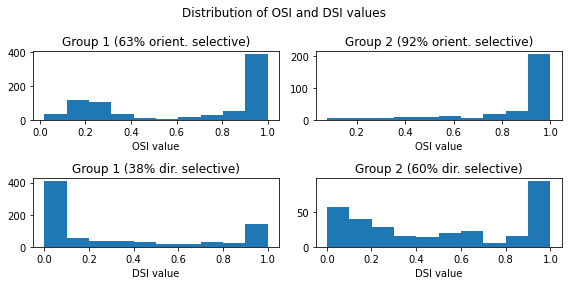

In [274]:
# Plot distribution of orientations/direction selectivity indices

# Get selectivity measures
OSIs_group1 = [u["OSI"] for u in physiology_data_group1]
OSIs_group2 = [u["OSI"] for u in physiology_data_group2]

DSIs_group1 = [u["DSI"] for u in physiology_data_group1]
DSIs_group2 = [u["DSI"] for u in physiology_data_group2]

# Calculate percent orientation selective
percent_OSI_selective_group1 = round(len([osi for osi in OSIs_group1 if osi > OSI_THRESH]) / len(physiology_data_group1) * 100)
percent_OSI_selective_group2 = round(len([osi for osi in OSIs_group2 if osi > OSI_THRESH]) / len(physiology_data_group2) * 100)

# Calculate percent direction selective
percent_DSI_selective_group1 = round(len([dsi for dsi in DSIs_group1 if dsi > DSI_THRESH]) / len(physiology_data_group1) * 100)
percent_DSI_selective_group2 = round(len([dsi for dsi in DSIs_group2 if dsi > DSI_THRESH]) / len(physiology_data_group2) * 100)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=plt.figaspect(1/2))

bins = 10

axs[0, 0].hist(OSIs_group1, bins=bins)
axs[0, 0].set_title("Group 1 ({}% orient. selective)".format(percent_OSI_selective_group1))
axs[0, 0].set_xlabel("OSI value")
axs[0, 1].hist(OSIs_group2, bins=bins)
axs[0, 1].set_title("Group 2 ({}% orient. selective)".format(percent_OSI_selective_group2))
axs[0, 1].set_xlabel("OSI value")

axs[1, 0].hist(DSIs_group1, bins=bins)
axs[1, 0].set_title("Group 1 ({}% dir. selective)".format(percent_DSI_selective_group1))
axs[1, 0].set_xlabel("DSI value")
axs[1, 1].hist(DSIs_group2, bins=bins)
axs[1, 1].set_title("Group 2 ({}% dir. selective)".format(percent_DSI_selective_group2))
axs[1, 1].set_xlabel("DSI value")

plt.suptitle("Distribution of OSI and DSI values")
plt.tight_layout()

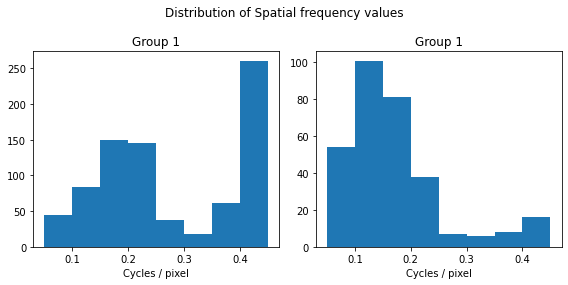

In [283]:
# Plot other data distributions

field_name = "Spatial frequency"
x_axis = "Cycles / pixel"
field = "sf"

# Get selectivity measures
values_group1 = np.array([u[field] for u in physiology_data_group1])
values_group2 = np.array([u[field] for u in physiology_data_group2])

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(1/2))

bins = 8

axs[0].hist(values_group1, bins=bins)
axs[0].set_title("Group 1")
axs[0].set_xlabel(x_axis)

axs[1].hist(values_group2, bins=bins)
axs[1].set_title("Group 1")
axs[1].set_xlabel(x_axis)

plt.suptitle("Distribution of {} values".format(field_name))
plt.tight_layout()

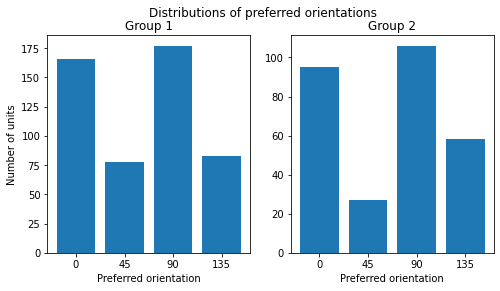

In [284]:
# Figure 5b

xlabels = [0, 45, 90, 135]
xpos = [0, 1, 2, 3]

def get_orientation_counts (physiology_data):
    orientations = [0, 0, 0, 0]
    
    for unit in physiology_data:
        if unit["OSI"] > OSI_THRESH:
            direction = unit["orientation"]
            if direction > 337.5 or direction <= 22.5:
                orientations[0] += 1
            elif direction > 22.5 and direction <= 67.5:
                orientations[1] += 1
            elif direction > 67.5 and direction <= 112.5:
                orientations[2] += 1
            elif direction > 112.5 and direction <= 157.5:
                orientations[3] += 1
            elif direction > 157.5 and direction <= 202.5:
                orientations[0] += 1
            elif direction > 202.5 and direction <= 247.5:
                orientations[1] += 1
            elif direction > 247.5 and direction <= 297.5:
                orientations[2] += 1
            else:
                orientations[3] += 1
    return orientations

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(1/2))

axs[0].bar(xpos, get_orientation_counts(physiology_data_group1))
axs[0].set_xticks(xpos)
axs[0].set_xticklabels(xlabels)
axs[0].set_xlabel("Preferred orientation")
axs[0].set_ylabel("Number of units")
axs[0].set_title("Group 1")

axs[1].bar(xpos, get_orientation_counts(physiology_data_group2))
axs[1].set_xticks(xpos)
axs[1].set_xticklabels(xlabels)
axs[1].set_xlabel("Preferred orientation")
axs[1].set_title("Group 2")

plt.suptitle('Distributions of preferred orientations')
plt.show()

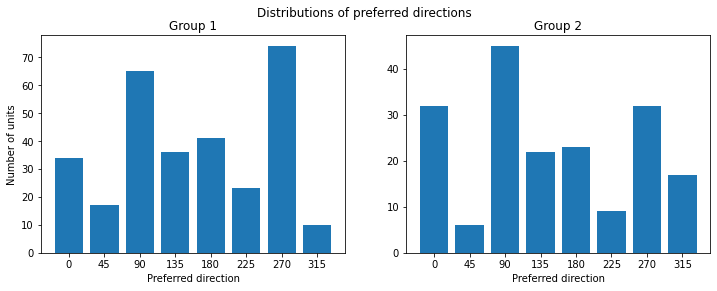

In [285]:
# Figure 6b

xlabels = [0, 45, 90, 135, 180, 225, 270, 315]
xpos = [0, 1, 2, 3, 4, 5, 6, 7]

def get_orientation_counts (physiology_data):
    orientations = [0, 0, 0, 0, 0, 0, 0, 0]
    
    for unit in physiology_data:
        if unit["DSI"] > DSI_THRESH:
            direction = unit["orientation"]
            if direction > 337.5 or direction <= 22.5:
                orientations[0] += 1
            elif direction > 22.5 and direction <= 67.5:
                orientations[1] += 1
            elif direction > 67.5 and direction <= 112.5:
                orientations[2] += 1
            elif direction > 112.5 and direction <= 157.5:
                orientations[3] += 1
            elif direction > 157.5 and direction <= 202.5:
                orientations[4] += 1
            elif direction > 202.5 and direction <= 247.5:
                orientations[5] += 1
            elif direction > 247.5 and direction <= 297.5:
                orientations[6] += 1
            else:
                orientations[7] += 1
    return orientations

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(1/3))

axs[0].bar(xpos, get_orientation_counts(physiology_data_group1))
axs[0].set_xticks(xpos)
axs[0].set_xticklabels(xlabels)
axs[0].set_xlabel("Preferred direction")
axs[0].set_ylabel("Number of units")
axs[0].set_title("Group 1")

axs[1].bar(xpos, get_orientation_counts(physiology_data_group2))
axs[1].set_xticks(xpos)
axs[1].set_xticklabels(xlabels)
axs[1].set_xlabel("Preferred direction")
axs[1].set_title("Group 2")

plt.suptitle('Distributions of preferred directions')
plt.show()

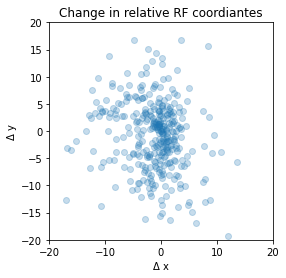

x mean = -1.3051498522040217, std = 4.689000940758135
y mean = -0.8148188265984501, std = 6.397168968778517

Difference = 1.7081680280203821 (> 1 indicates greater spread along y)

Proportion < 0 = 50.59%


In [376]:
# Get relative dx dy for a given point

import math

def get_dx_dy (V1_unit, V2_unit):
    rad_angle = V2_unit["orientation"] * math.pi/180 # Orientation angle in radians
    rotation_matrix = np.array([
        [math.cos(-rad_angle), -math.sin(-rad_angle)],
        [math.sin(-rad_angle),  math.cos(-rad_angle)]
    ])
    
    V1_point = np.array([V1_unit["position"][1], V1_unit["position"][0]]) # Reverse because stored as row, col
    V2_point = np.array([V2_unit["position"][1], V2_unit["position"][0]])
    
    V1_point_rot = np.dot(rotation_matrix, V1_point)
    V2_point_rot = np.dot(rotation_matrix, V2_point)
    
    dx = V1_point_rot[0] - V2_point_rot[0]
    dy = V1_point_rot[1] - V2_point_rot[1]
    
    return dx, dy

weights = model.rnn.weight_hh_l0.cpu().detach().numpy()
normed_weights = (weights-np.mean(weights))/np.std(weights)

x = []
y = []
weights = []

units = [
    177, 184, 187, 212, 257, 297, 230, 165, 141, 127,
    129,  94,  70,  57,  32,   7,  10,  24,  34,  53,
      60, 75, 132, 146, 158, 160, 173, 178, 179, 186,
     190, 209,  206, 202, 216
    
]

for pre_unit in physiology_data_group2[units]:
    for post_unit in physiology_data_group1:
        connection_weight = normed_weights[post_unit["unit_idx"], pre_unit["unit_idx"]]
        
        if (
            not np.isnan(pre_unit["position"][0]) and
            not np.isnan(post_unit["position"][0]) and
            pre_unit["position"][0] <= 20 and pre_unit["position"][0] >= 0 and
            pre_unit["position"][1] <= 20 and pre_unit["position"][1] >= 0 and
            pre_unit["OSI"] > OSI_THRESH and
            post_unit["OSI"] > OSI_THRESH and
            abs(connection_weight) > 2.5
        ):  
            dx, dy = get_dx_dy(V1_unit=post_unit, V2_unit=pre_unit)
            #dx, dy = np.random.normal(loc=0, scale=4), np.random.normal(loc=0, scale=4)
            x.append(dx)
            y.append(dy)
            weights.append(abs(connection_weight))
    
fig = plt.figure(figsize=plt.figaspect(1))
plt.scatter(x, y, cmap='gray', alpha=0.25)
plt.xlim([-20, 20])
plt.ylim([-20, 20])
plt.xlabel("Δ x")
plt.ylabel("Δ y")
plt.title("Change in relative RF coordiantes")
plt.show()


print('x mean = {}, std = {}\ny mean = {}, std = {}'.format(
    np.nanmean(x),
    np.nanstd(x),
    np.nanmean(y),
    np.nanstd(y)
))
print('\nDifference = {} (> 1 indicates greater spread along y)'.format(np.nanstd(y)-np.nanstd(x)))

y = np.array(y)
prop_above_0 = round(len(y[y < 0]) / len(y) * 100, 2)

print("\nProportion < 0 = {}%".format(prop_above_0))

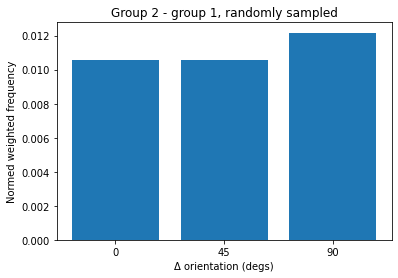

(0.0013479029565357293, 0.6088297073675484)

In [303]:
# Weight strength as a function of orientation difference

weights = model.rnn.weight_hh_l0.cpu().detach().numpy()

difference_values = []
weight_strengths = []

orientations_group1 = np.array([u["orientation"] for u in physiology_data_group1])
orientations_group2 = np.array([u["orientation"] for u in physiology_data_group2])

for post_unit in physiology_data_group1:
    for pre_unit in physiology_data_group2:
        connection_weight = weights[post_unit["unit_idx"], pre_unit["unit_idx"]]
        a1, a2 = pre_unit["orientation"], post_unit["orientation"]
        #a1, a2 = np.random.choice(orientations_group2, replace=False), np.random.choice(orientations_group1, replace=False)
        
        a_delta = 90 - abs(abs((a1 - a2)%180) - 90);
        
        if (
            post_unit["OSI"] > OSI_THRESH and
            pre_unit["OSI"] > OSI_THRESH
        ):
            difference_values.append(a_delta)
            weight_strengths.append(connection_weight)

hist, edges = np.histogram(
    difference_values,
    bins=[0, 30, 60, 90],
    weights=np.abs(weight_strengths),
    density=True
)
            
# Plot histogram
fig, ax = plt.subplots()

ax.bar(["0", "45", "90"], hist)
ax.set_title("Group 2 - group 1")
ax.set_xlabel("Δ orientation (degs)")
ax.set_ylabel("Normed weighted frequency")

plt.show()

scipy.stats.pearsonr(difference_values, weight_strengths)

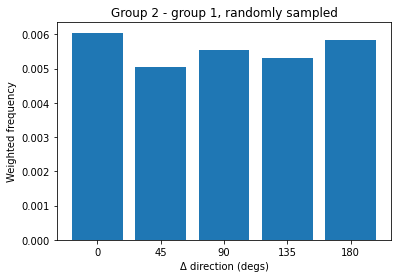

(0.005511423223805865, 0.19295384868209922)

In [306]:
# Weight strength as a function of direciton difference

weights = model.rnn.weight_hh_l0.cpu().detach().numpy()

difference_values = []
weight_strengths = []

orientations_group1 = np.array([u["orientation"] for u in physiology_data_group1])
orientations_group2 = np.array([u["orientation"] for u in physiology_data_group2])

for post_unit in physiology_data_group1:
    for pre_unit in physiology_data_group2:
        connection_weight = normed_weights[post_unit["unit_idx"], pre_unit["unit_idx"]]
        a1, a2 = pre_unit["orientation"], post_unit["orientation"]
        #a1, a2 = np.random.choice(orientations_group2, replace=False), np.random.choice(orientations_group1, replace=False)
        a_delta = 180 - abs(abs((a1 - a2)%360) - 180);
        
        if (
            post_unit["DSI"] > DSI_THRESH and
            pre_unit["DSI"] > DSI_THRESH
        ):
            difference_values.append(a_delta)
            weight_strengths.append(connection_weight)

hist, edges = np.histogram(
    difference_values,
    bins=[0, 36, 72, 108, 144, 180],
    weights=np.abs(weight_strengths),
    density=True
)

# Plot histogram
fig, ax = plt.subplots()

ax.bar(["0", "45", "90", "135", "180"], hist)
ax.set_title("Group 2 - group 1")
ax.set_xlabel("Δ direction (degs)")
ax.set_ylabel("Weighted frequency")

plt.show()

scipy.stats.pearsonr(difference_values, weight_strengths)

Power_divergenceResult(statistic=array([ 5.5978836 , 12.44827586]), pvalue=array([0.01798219, 0.00041838]))

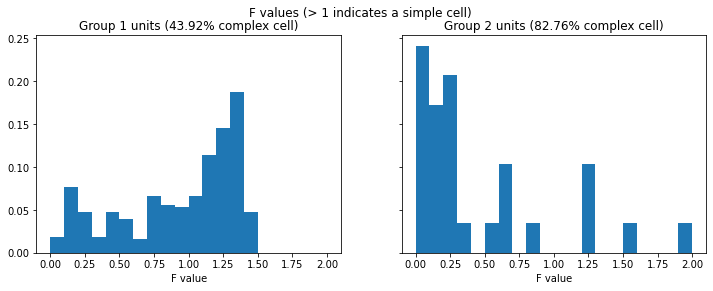

In [307]:
outlier_thresh = 2

max_mean_response_1 = max(u['mean_response'] for u in physiology_data_group1)
max_mean_response_2 = max(u['mean_response'] for u in physiology_data_group2)

f_values_1 = []
for unit in physiology_data_group1:
    f = unit["f"]
    if f != False and unit["mean_response"] > (0.01*max_mean_response_1):
        f_values_1.append(f)
f_values_1 = np.array(f_values_1)
weights_1 = np.ones_like(f_values_1) / float(len(f_values_1))
complex_cell_prop_1 = round(len(f_values_1[f_values_1 <= 1]) / len(f_values_1) * 100, 2)
    
f_values_2 = []
for unit in physiology_data_group2:
    f = unit["f"]
    if f != False and unit["mean_response"] > (0.01*max_mean_response_2):
        f_values_2.append(f)
f_values_2 = np.array(f_values_2)
weights_2 = np.ones_like(f_values_2) / float(len(f_values_2))
complex_cell_prop_2 = round(len(f_values_2[f_values_2 <= 1]) / len(f_values_2) * 100, 2)

bins = np.arange(0, outlier_thresh+0.1, 0.1)
xlabels = np.round(bins, 1).astype(str)
xlabels[-1] += '+'
nlabels = len(xlabels)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(1/3), sharex=True, sharey=True)
axs[0].hist(np.clip(f_values_1, bins[0], bins[-1]), bins=bins, weights=weights_1)
axs[0].set_title("Group 1 units ({}% complex cell)".format(complex_cell_prop_1))
axs[0].set_xlabel("F value")
#axs[0].set_xticks(bins)
#axs[0].set_xticklabels(xlabels)
#axs[0].set_xlim([0, outlier_thresh])

axs[1].hist(np.clip(f_values_2, bins[0], bins[-1]), bins=bins, weights=weights_2)
axs[1].set_title("Group 2 units ({}% complex cell)".format(complex_cell_prop_2))
axs[1].set_xlabel("F value")
fig.suptitle('F values (> 1 indicates a simple cell)')

f_values_1_complex = len(f_values_1[f_values_1 <= 1])
f_values_2_complex = len(f_values_2[f_values_2 <= 1])
f_values_1_simple = len(f_values_1[f_values_1 > 1])
f_values_2_simple = len(f_values_2[f_values_2 > 1])

chi_sq = np.array([
    [f_values_1_complex, f_values_2_complex],
    [f_values_1_simple, f_values_2_simple]
])

scipy.stats.chisquare(chi_sq)